# Temporal Demand Patterns and Price Analysis

To analyze the taxi trip data of Chicago from the year 2015, this notebook will visualize how the taxi usage varies for different time frames and weather conditions. We will also take a closer look at the financial aspect of the taxi trips.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import geopandas
from shapely import wkt

In [2]:
#Import cleaned dataset

trips_df = pd.read_parquet('../../data/rides/Taxi_Trips_Sampled_Cleaned.parquet')
trips_df.head(3)

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,h3_07_dropoff,h3_08_pickup,h3_08_dropoff,h3_09_pickup,h3_09_dropoff,pickup_centroid,dropoff_centroid,datetime,temp,precip
0,1,2015-01-01 00:00:00,2015-01-01 00:00:00,540.0,0.17,17031080300,17031063301,8,6,7.25,...,872664c10ffffff,882664c13bfffff,882664c101fffff,892664c13afffff,892664c101bffff,POINT (-87.63576009 41.90749193),POINT (-87.643022804 41.934539716),2015-01-01,-7.0115,0
1,2,2015-01-01 00:00:00,2015-01-01 00:00:00,480.0,0.90,17031320100,17031081500,32,8,6.25,...,872664c1effffff,882664c1e3fffff,882664c1e1fffff,892664c1e2fffff,892664c1e0fffff,POINT (-87.620992913 41.884987192),POINT (-87.626214906 41.892507781),2015-01-01,-7.0115,0
2,3,2015-01-01 00:15:00,2015-01-01 00:30:00,780.0,5.50,17031281900,17031063301,28,6,14.05,...,872664c10ffffff,882664c1adfffff,882664c101fffff,892664c1acfffff,892664c101bffff,POINT (-87.642648998 41.879255084),POINT (-87.643022804 41.934539716),2015-01-01,-7.0115,0


In [3]:
#Simplify times to full hour
trips_df['start_time_hour'] = trips_df['trip_start_timestamp'].dt.floor('1H')
trips_df['end_time_hour'] = trips_df['trip_end_timestamp'].dt.floor('1H')

#Calculation of started and finished trips per hour
trips_starting = (trips_df.groupby(["start_time_hour"]).size().to_frame("trips_starting"))
trips_ending = (trips_df.groupby(["end_time_hour"]).size().to_frame("trips_ending"))

#Combine DFs and fill empty values
trips_hourly = pd.concat([trips_starting, trips_ending, ], axis=1)
trips_hourly = trips_hourly.fillna(0)

#Calculate difference of trips
trips_hourly['trips_diff'] = trips_hourly['trips_starting'] - trips_hourly['trips_ending']
trips_hourly['trips_active'] = trips_hourly['trips_diff'].cumsum()
trips_hourly['trips_prev_active'] = trips_hourly['trips_active'].shift(1)

#Keep only relevant features
trips_hourly = trips_hourly[['trips_starting', 'trips_prev_active']]

#Remove unavailable entries
trips_hourly = trips_hourly.dropna()

trips_hourly["ongoing_trips"] = trips_hourly["trips_starting"] + trips_hourly["trips_prev_active"]

#Add columns for different timeframes
trips_hourly['day_of_year'] = trips_hourly.index.day_of_year
trips_hourly['hour'] = trips_hourly.index.hour
trips_hourly['day_of_week'] = trips_hourly.index.day_of_week
trips_hourly['month'] = trips_hourly.index.month

trips_hourly.head(3)

,trips_starting,trips_prev_active,ongoing_trips,day_of_year,hour,day_of_week,month
2015-01-01 01:00:00,70.0,8.0,78.0,1,1,3,1
2015-01-01 02:00:00,91.0,22.0,113.0,1,2,3,1
2015-01-01 03:00:00,57.0,18.0,75.0,1,3,3,1


In [4]:
# Create a copy of the 'trips_df' DataFrame and set the floored datetime as the index
trips_df_copy = trips_df.copy()
trips_df_copy.set_index(trips_df_copy['trip_start_timestamp'].dt.floor('H'), inplace=True)

# Select the relevant columns from 'trips_df_copy' to merge into 'trips_hourly'
precip_columns = ['precip']

# Create a new DataFrame with only the relevant columns from 'trips_df_copy'
precip_data = trips_df_copy[precip_columns]

# Merge 'precip_data' into 'trips_hourly' based on the datetime index
trips_hourly_with_precip = trips_hourly.merge(precip_data, left_index=True, right_index=True, how='left')
trips_hourly_with_precip = trips_hourly_with_precip.reset_index()

trips_hourly_with_precip = trips_hourly_with_precip.drop_duplicates(subset=['index'])

trips_hourly_with_precip.head(3)

,index,trips_starting,trips_prev_active,ongoing_trips,day_of_year,hour,day_of_week,month,precip
0,2015-01-01 01:00:00,70.0,8.0,78.0,1,1,3,1,0.0
70,2015-01-01 02:00:00,91.0,22.0,113.0,1,2,3,1,0.0
161,2015-01-01 03:00:00,57.0,18.0,75.0,1,3,3,1,0.0


## Taxi Usage

First, we will look at the demand patterns for different timeframes:

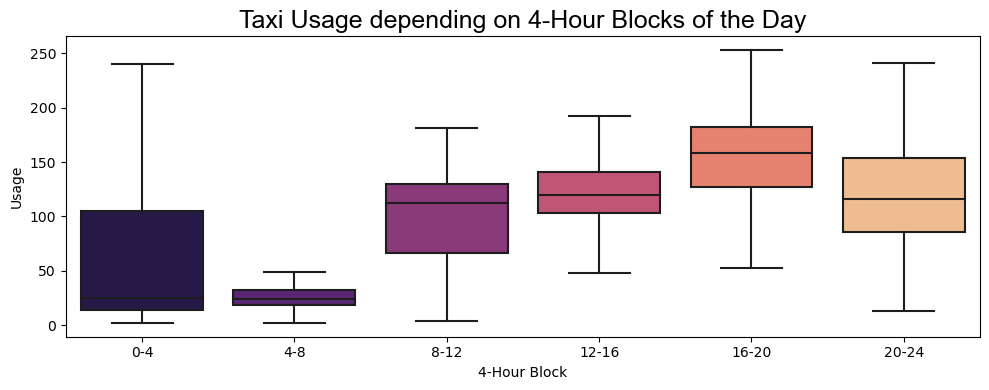

In [5]:
# Create a new column for the 4-hour blocks
trips_hourly['4_hour_block'] = trips_hourly['hour'] // 4

# Group by the new 4-hour block column and aggregate the data
trips_hourly_block = trips_hourly.groupby(['day_of_year', '4_hour_block'])[['trips_starting', 'trips_prev_active', 'ongoing_trips']].sum().reset_index()

# Displaying values graphically
fig, ax = plt.subplots(figsize=(10, 4))
x_labels = ['0-4', '4-8', '8-12', '12-16', '16-20', '20-24']

sns.boxplot(x=trips_hourly_block['4_hour_block'], y=trips_hourly_block['ongoing_trips'], ax=ax, palette='magma', showfliers=False)
ax.set_title('Taxi Usage depending on 4-Hour Blocks of the Day', fontsize=18, fontname='Arial')
ax.set_xlabel('4-Hour Block')
ax.set_xticklabels(x_labels)
ax.set_ylabel('Usage')
plt.tight_layout()
plt.show()

Looking at the taxi usage in four hour blocks, we can see that the most taxis are used from 4pm-8pm while the least taxis are used from 4am-8am. Secondly, we can see that the demand starts to rise starting from 8am, reaches its peak from 4pm-8pm and then begins to lower again.
The fluctuation for trips from 12pm-4am is the highest, which can probably be explained by people going out during the weekends and taking a taxi home which probably does not happen during the work week.

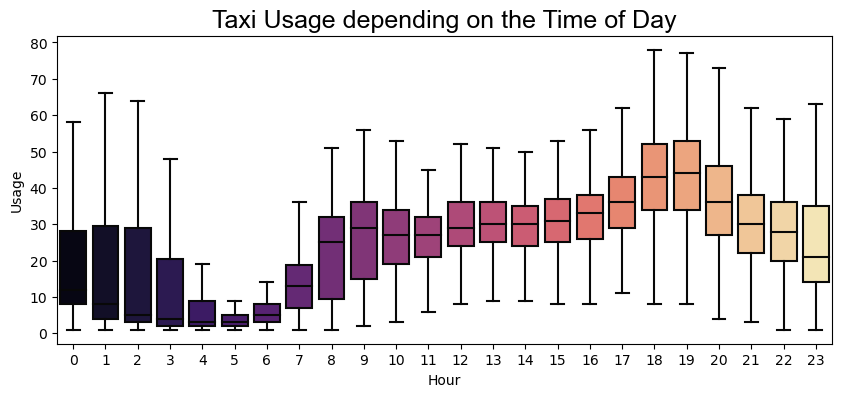

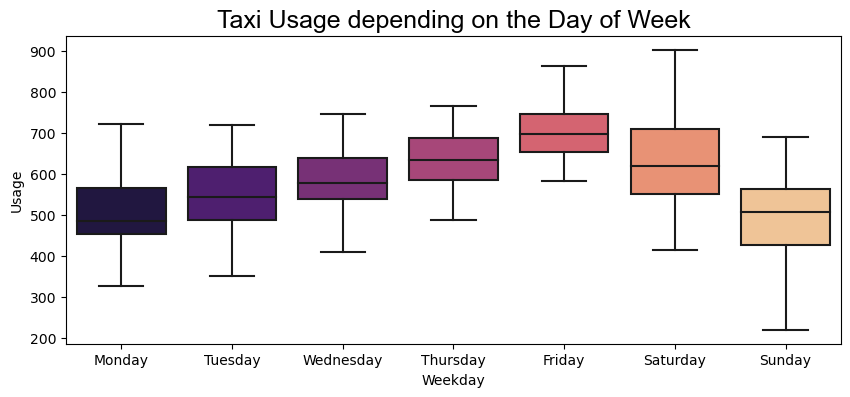

In [6]:
trips_hourly_hour = trips_hourly.groupby(["day_of_year","hour"])["ongoing_trips"].sum()
trips_hourly_hour = pd.DataFrame(trips_hourly_hour)
hour=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

fig, ax1 = plt.subplots(figsize=(10, 4))
sns.boxplot(x=trips_hourly_hour.index.get_level_values(1), y=trips_hourly_hour["ongoing_trips"], ax=ax1, palette="magma", showfliers=False)
ax1.set_title("Taxi Usage depending on the Time of Day", fontsize=18, fontname="Arial")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Usage")
ax1.set_xticklabels(hour)


weekday=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
trips_hourly_week = trips_hourly.groupby(["day_of_year","day_of_week"])["ongoing_trips"].sum()
trips_hourly_week = pd.DataFrame(trips_hourly_week)

fig, ax2 = plt.subplots(figsize=(10, 4))
sns.boxplot(x=trips_hourly_week.index.get_level_values(1), y=trips_hourly_week["ongoing_trips"], ax=ax2, palette="magma", showfliers=False)
ax2.set_title("Taxi Usage depending on the Day of Week", fontsize=18, fontname="Arial")
ax2.set_xlabel("Weekday")
ax2.set_ylabel("Usage")
ax2.set_xticklabels(weekday)
plt.show()

Taking a closer look at each individual hour, we can identify 5am as the time with the least taxi trips and small demand during the early morning hours. Starting from 7am, the demand slowly rises and reaches its first peak at 9am with an increased demand the hour before and after. The taxi usage then stays fairly constant during the day before rising slowly towards the next peak from 6pm-7pm. This is the time with the highest demand for taxis which is probably linked to the evening rush hour and people going home from work with a taxi. The demand then falls again and is generally a littler lower during the night than during the day (early morning hours excluded).

Considering the second plot, we can come to the conclusion that most taxi trips happen on Friday which is likely linked to the normal work week commuters and people going out at the end of the work week and not driving themselves because they might want to drink alcohol or head downtown where parking space is sparse. Saturday has the third highest number of taxi trips which supports this assumption. Other than that, the plot shows that the demand for taxis rises during the week and that each day of the work week has a similar variance. The demand on Saturday and Sunday is fluctuating a lot more which probably has to do with weekend activities that might depend on the weather or current events in town. Sunday is also the day with the smallest taxi usage.


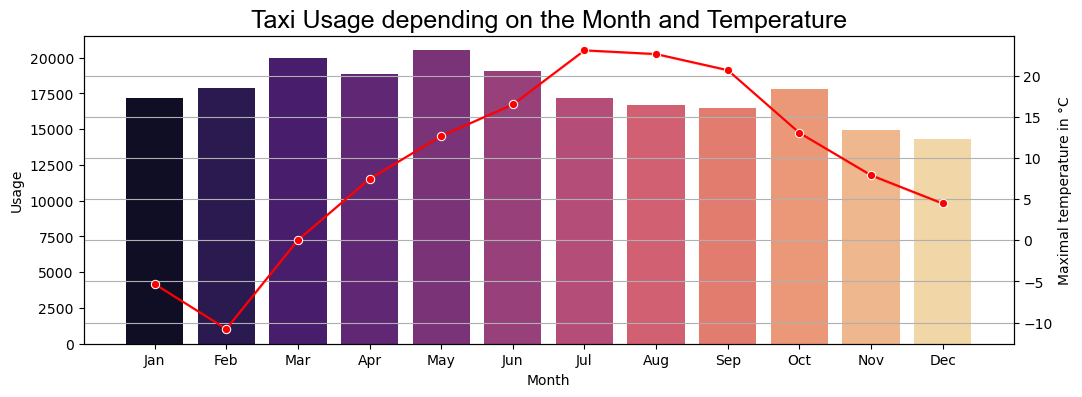

In [23]:
trips_monthly = trips_hourly.groupby(["month"])["ongoing_trips"].sum().reset_index()
trips_monthly = pd.DataFrame(trips_monthly)

fig,ax = plt.subplots(figsize=(12,4)) 
x_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.barplot(data=trips_monthly, x="month", y="ongoing_trips", palette="magma", ax=ax)
ax.set_title("Taxi Usage depending on the Month and Temperature", fontsize=18, fontname="Arial")
ax.set_xticklabels(x_labels)
ax.set_xlabel("Month")
ax.set_ylabel("Usage")

ax2 = ax.twinx()
# month start -1 to fit it to the taxi usage 
sns.lineplot(x=(trips_df["month_start"]-1), y=trips_df["temp"], ax=ax2, color='red', marker='o')
ax2.set_ylabel("Maximal temperature in °C")
ax2.yaxis.grid(True)
#ax.yaxis.grid(False)

Moving on to the monthly demand, the plot shows that the most taxis are used during the first half of year (January-June). This can likely be connected to the temperature since people are probably more likely to take a taxi from January to March because of the temperatures under or around 0°C when walking or biking for a longer time is probably uncomfortable. From March-June we observe the highest demand for taxis while the temperatures are rising from 0°C to around 16°C in June. Once the temperature is over 20°C, the demand for taxis falls from July-September as people are probably walking and using their bikes more with milder temperatures. Starting from October-December the temperatures fall again and the demand for taxis rises in October. Interestingly November and December have the lowest demand for taxis which could be linked to the holiday season and less tourists coming to Chicago in winter.

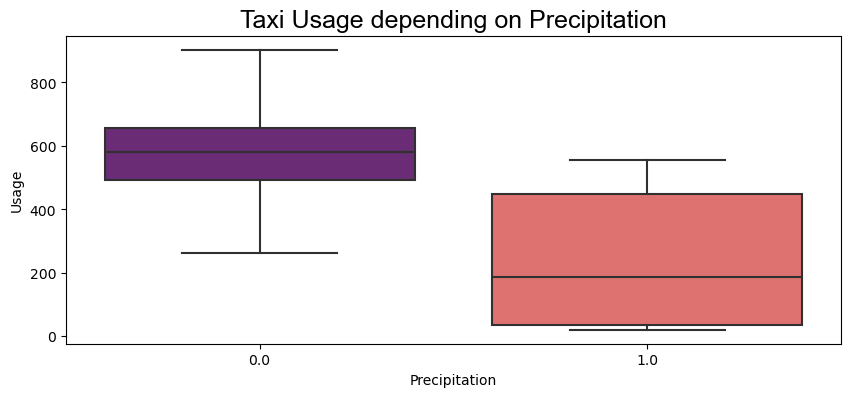

In [27]:
#group by precipitation and plot
trips_precip = trips_hourly_with_precip.groupby(["day_of_year","precip"])["ongoing_trips"].sum()
trips_precip = pd.DataFrame(trips_precip)

fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=trips_precip.index.get_level_values(1), y=trips_precip["ongoing_trips"],ax=ax, palette="magma", showfliers=False)
ax.set_title("Taxi Usage depending on Precipitation", fontsize=18, fontname="Arial")
ax.set_xlabel("Precipitation")
ax.set_ylabel("Usage")

plt.show()

Considering precipitation, the plot above shows that significantly more taxi trips happen during days with no rain. This surprised us because one would think that people would use taxis more when its raining than on days with good weather.
Thus, we will take a closer look at the ratio of days with and without precipitation in Chicago:

In [10]:
trips_precip = trips_precip.reset_index()

precip_count = (trips_precip['precip'] == 1.0).sum()
non_precip_count = (trips_precip['precip'] == 0.0).sum()

ratio = precip_count / non_precip_count

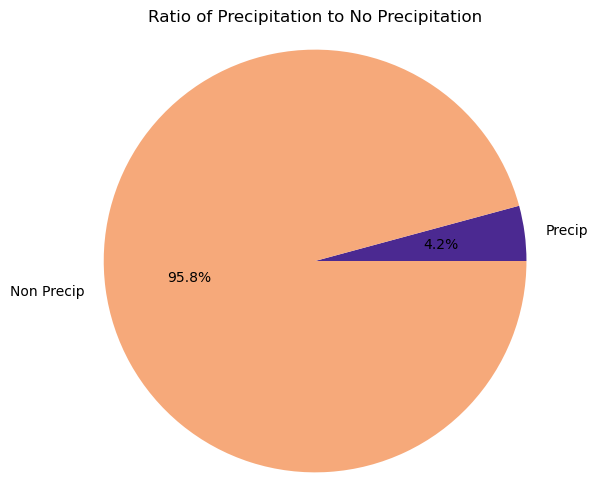

In [11]:
categories = ['Precip', 'Non Precip']
values = [precip_count, non_precip_count]
colors = ["#4B2991", "#F6A97A"]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=categories, colors=colors, autopct='%1.1f%%',startangle=0 )
plt.title('Ratio of Precipitation to No Precipitation')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Taking the ratio of precipitation to no precipitation into consideration, the results above seem more logical now, because we can see that it barely rains in Chicago (only 4.2% of the trips had precipitation) and the vast majority of trips had no precipitation (95.8%). Thus, bad weather in Chicago might make people go out less as it is only a rare occasion that they are not used to. This also results in less taxi trips during rainy weather, contrary to our initial beliefs.

### Price analysis

Next, we will move on to the price analysis where we analyze the total fares, tips and payment types. 

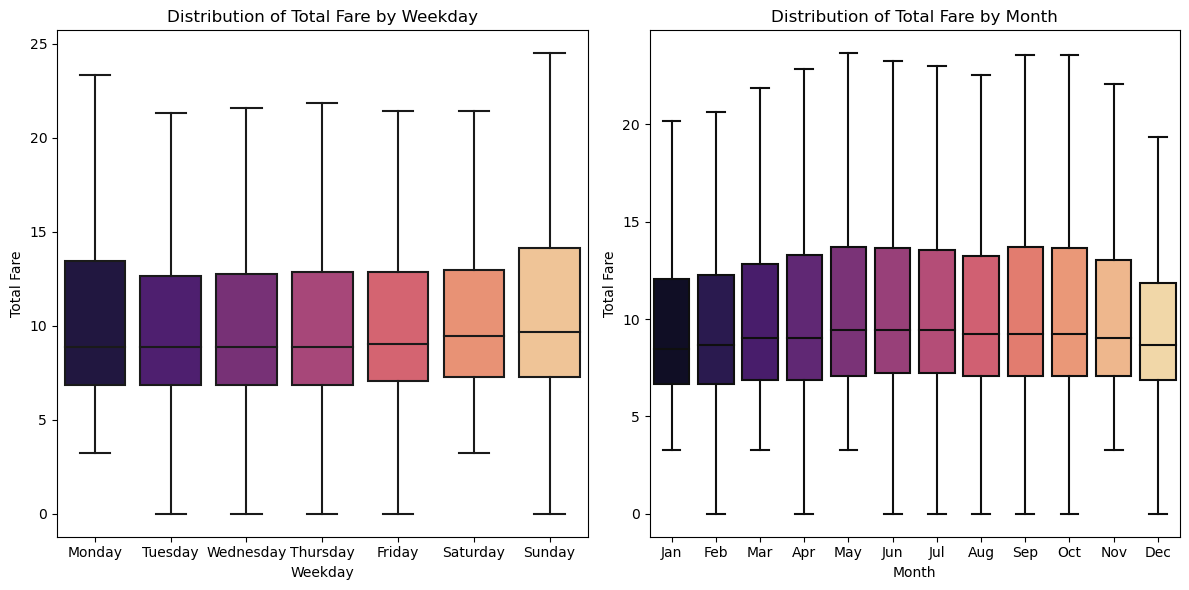

In [12]:
plt.figure(figsize=(12, 6))

# Boxplot for weekday
plt.subplot(1, 2, 1)
sns.boxplot(data=trips_df, x="dayofweek_start", y="trip_total", palette="magma", showfliers=False)
plt.title("Distribution of Total Fare by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Total Fare")
plt.xticks(range(7), weekday)

# Boxplot for month
plt.subplot(1, 2, 2)
sns.boxplot(data=trips_df, x="month_start", y="trip_total", palette="magma", showfliers=False)
plt.title("Distribution of Total Fare by Month")
plt.xlabel("Month")
plt.ylabel("Total Fare")
plt.xticks(range(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.tight_layout()
plt.show()


Starting with the total fare per weekday, the left plot shows that the median of the total fare is similar for all the weekdays and lies around 8$. The variance for each weekday is similar as well with Monday and Sunday showing a bit more fluctuation. Overall, we can see that trips during the work week are similar in median and variance which might be due to the fact that they are routine commutes to work or fixed appointements. The higher variance on Sunday might be linked to leisure activites like attending events that are irregular and cause more demand fluctation on this day. <b>

Moving on to the total fare per month, we can conclude that the median of the total fare slightly rises from January to June which is the month with the highest median. Afterwards the median falls slightly again till the end of the year. The general median through the year ranges from approximately 7-9$. The variance through the year stays fairly constant. September and October display a slightly higher variance in total fares than the other months though. This can probably be explained by the start of fall and the weather alternating more where people might use the last warm days to make longer trips or take a taxi when the weather is not so good.

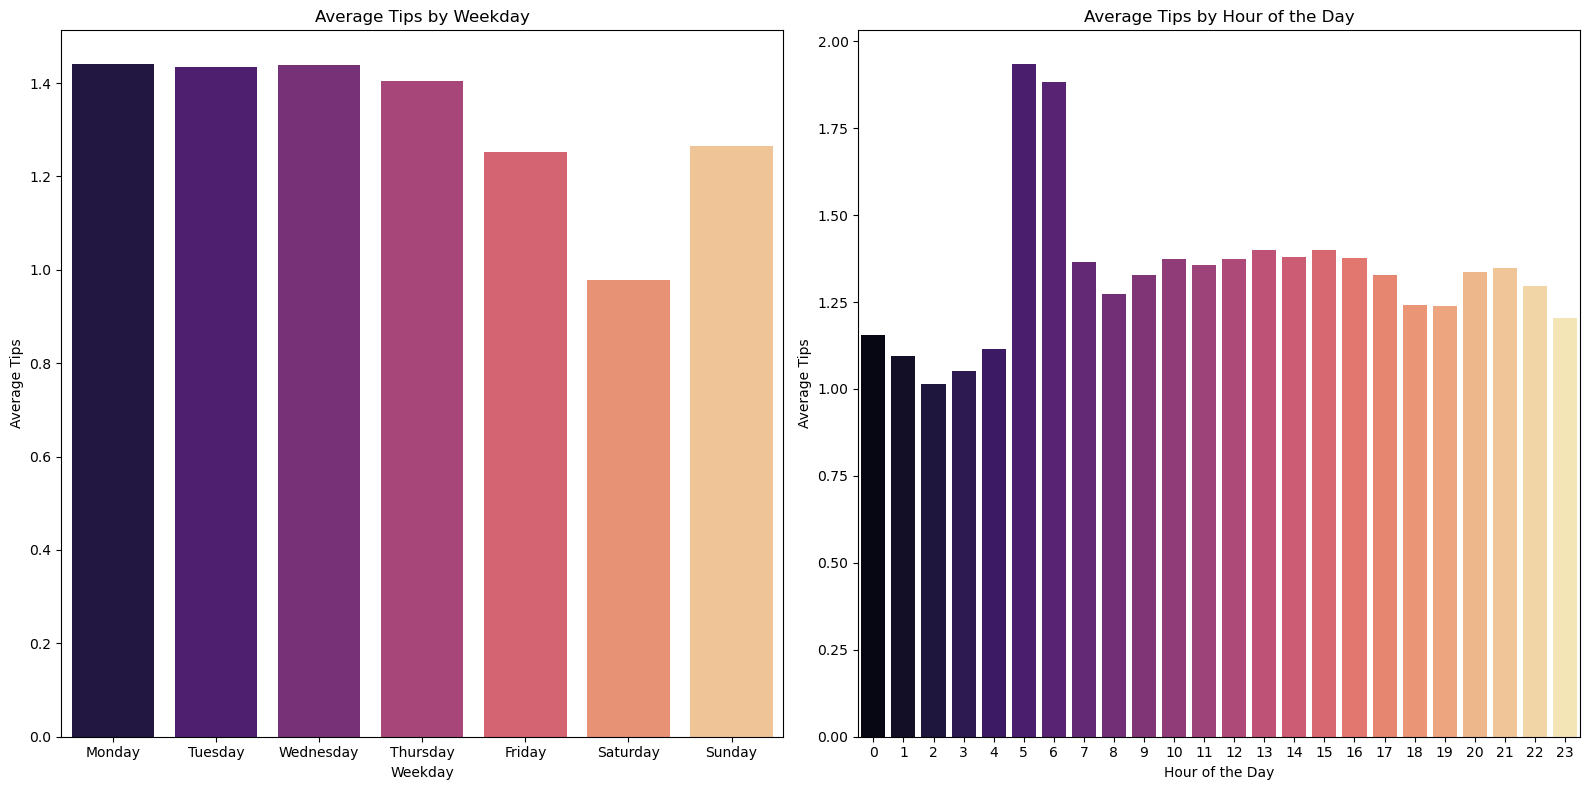

In [13]:
plt.figure(figsize=(16, 8))
# Group by hour and calculate the average of tips for each hour
tips_by_hour = trips_df.groupby('hour_end')['tips'].mean().reset_index()

plt.subplot(1, 2, 2)
sns.barplot(x='hour_end', y='tips', palette="magma", data=tips_by_hour)
plt.xlabel('Hour of the Day')
plt.ylabel('Average Tips')
plt.title('Average Tips by Hour of the Day in $')

# Group by weekday and calculate the average of tips for each weekday
tips_by_weekday = trips_df.groupby('dayofweek_end')['tips'].mean().reset_index()

# Create a bar plot for average tips by weekday
plt.subplot(1, 2, 1)
sns.barplot(x='dayofweek_end', y='tips', palette="magma", data=tips_by_weekday)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Weekday')
plt.ylabel('Average Tips')
plt.title('Average Tips by Weekday in $')

plt.tight_layout()
plt.show()


For the average tips during the week, one can infer from the left plot that people give the most tips from Monday to Thursday with around 1.40 dollar. The average tips on Thursday are the highest. The tips on the weekend (including Friday) are lower. While the tips on Friday and Sunday are comparable and around 1.20 dollar, the average tips on Saturday are the lowest with 1 dollar. The difference in tips between the start of the week and the weekend could be linked to the overall taxi usage. Above, we have seen that the taxi usage from Monday-Thursday is lower than on Friday and Sunday so the service during those days might be better and customers might tip more then. On Saturdays customers might tip less because they might already spent money while going out and thus have less of a budget for additional spendings. <br>
Considering the hour of the day, one can clearly identify that the highest average tips are given at 5am and 6am. As seen before, we found out that 5am is the time with the least taxi trips and there is probably not a lot of traffic on the streets this early, so one can assume that the taxi trips from 5-6am are fast and convenient and that is why the tips are above average. Tips between 1am-4am are the lowest on average, which could be linked to the high variance of taxi demand we saw in the 4 hour block boxplot. The baseline for taxi demand is fairly low during this timeframe, so there might not be that many active taxis and people might have to wait longer for a free one which could lower their willingness to tip higher amounts.

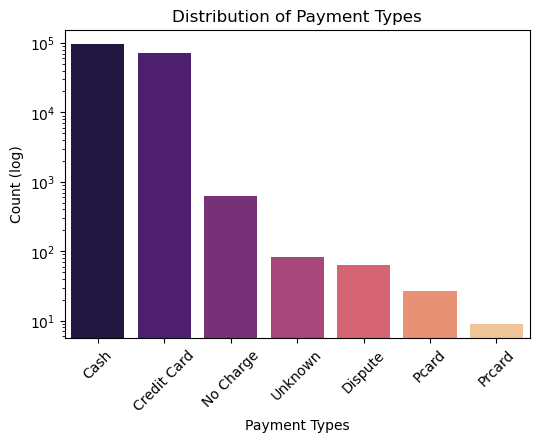

In [14]:
payment_counts = trips_df["payment_type"].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=payment_counts.index, y=payment_counts.values, palette="magma")
plt.title('Distribution of Payment Types')
plt.xlabel('Payment Types')
plt.ylabel('Count (log)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

Analyzing the payment types, we can see that a majority of trips are paid cash or with credit card. To give an overview over other payment methods, we logged the y-scale so that the magnitude of cash and cards payments does not visually overwhelm the smaller values. This revelas Pcards and Prcards as other payment methods, even though they are only used by a small fraction of customers, while the other "payment types" all resulted in the charge not being payed for the reasons listed in the plot.

In [15]:
 # Import necessary packages
import csv

csv_file = '../../data/census_tract/chicago_census_tract.csv'

# Create an empty dictionary
data_dict = {}

# Open the CSV file
with open(csv_file, 'r') as file:
    reader = csv.reader(file)

    # Skip the header row if present
    next(reader)

    # Iterate over each row in the CSV file
    for row in reader:
        ca = row[1]  # CA is in the second column
        community = row[2]  # COMMUNIT_1 is in the third column

        # Add the data to the dictionary
        data_dict[ca] = community

# Print the resulting dictionary
data_dict = dict(sorted(data_dict.items(), key=lambda item: int(item[0])))

# Create a new dictionary with integer keys
new_data_dict = {int(key): value for key, value in data_dict.items()}

key_types = [type(key) for key in new_data_dict.keys()]
trips_df['pickup_name'] = trips_df['pickup_community_area'].map(new_data_dict)
trips_df['dropoff_name'] = trips_df['dropoff_community_area'].map(new_data_dict)

In [16]:
#Calculate average trip total for each pickup community area

average_fare_per_pickup = trips_df.groupby('pickup_name')['trip_total'].mean().reset_index()
average_fare_per_pickup.sort_values(by='pickup_name', inplace=True)
average_fare_per_pickup.head(3)

,pickup_name,trip_total
0,Albany Park,19.650833
1,Armour Square,13.795676
2,Avondale,13.035500


In [17]:
#Extract latitudes and longitudes for the pickups
#taken from https://geopandas.org/en/stable/gallery/plotting_with_folium.html 

trips_df["pickup_centroid"] = geopandas.GeoSeries.from_wkt(trips_df["pickup_centroid"])
trips_df.set_geometry('pickup_centroid')

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in trips_df.pickup_centroid]

In [18]:
#Save coordinates into a separate dataframe

geo_df_pickup = geopandas.GeoDataFrame(geo_df_list, trips_df["pickup_name"])
geo_df_pickup

geo_df_pickup = geo_df_pickup.reset_index()
geo_df_pickup.head(3)

,pickup_name,0,1
0,Near North Side,41.907492,-87.635760
1,Loop,41.884987,-87.620993
2,Near West Side,41.879255,-87.642649


In [19]:
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [20]:
#Calculate the distance from each community area pick up centroid to the city centre

geo_df_pickup["centre_distance"] = haversine(
    geo_df_pickup[0],
    geo_df_pickup[1],
    41.881832, 
    -87.623177,
)

geo_df_pickup.sort_values(by='pickup_name', inplace=True)
geo_df_pickup.head(3)

,pickup_name,0,1,centre_distance
152837,Albany Park,41.969206,-87.723169,11.118606
102345,Albany Park,41.969206,-87.723169,11.118606
282,Albany Park,41.969206,-87.723169,11.118606


<br>
Next, we considered the pickup community area for each taxi trip to find out if there is a correlation between the average total fare per community area and how far it is from Chicago's city centre. First, we will visualize the trips per pickup community area and how far they are from the city centre in two barplots:
<br>

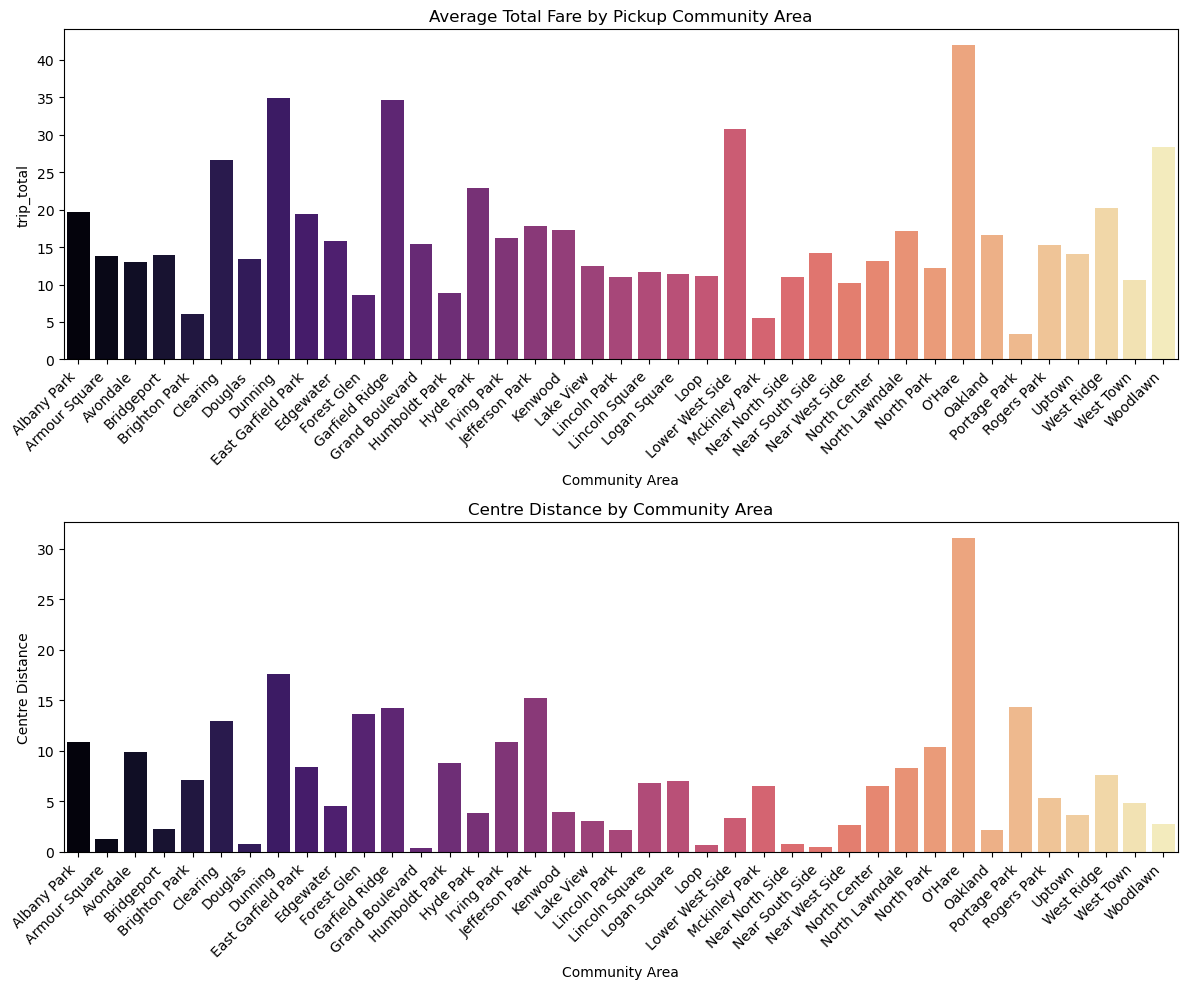

In [21]:
# Create a grid of subplots (2 rows, 1 column)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# First subplot (above)
sns.barplot(x=average_fare_per_pickup["pickup_name"], y=average_fare_per_pickup["trip_total"], palette="magma", ax=axes[0])
axes[0].set_title("Average Total Fare by Pickup Community Area")
axes[0].set_xlabel("Community Area")


# Second subplot (below)
sns.barplot(x=geo_df_pickup["pickup_name"], y=geo_df_pickup["centre_distance"], palette="magma", ax=axes[1], errorbar=None)
axes[1].set_title("Centre Distance by Community Area")
axes[1].set_xlabel("Community Area")
axes[1].set_ylabel("Centre Distance")

 # Adjust x-label rotation and alignment for both subplots
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


plt.tight_layout()  # Ensure proper layout of subplots
plt.show()


From the first plot, we can infer that trips starting in O'Hare have the highest average fare which makes sense as it is also the furthest away from central Chicago and trips starting there probably cover a bigger distance. Dunning and Garfield Ridge have the second and third highest fares per pickup community area while trips starting at Mckinley Park or Rogers Park have the lowest average total. Here, the distance to the city centre seems to have no influence. To have a better overview whether the distance of the pickup community area to the city centre has an impact on the total fare, we will plot those two variables in a scatterplot:

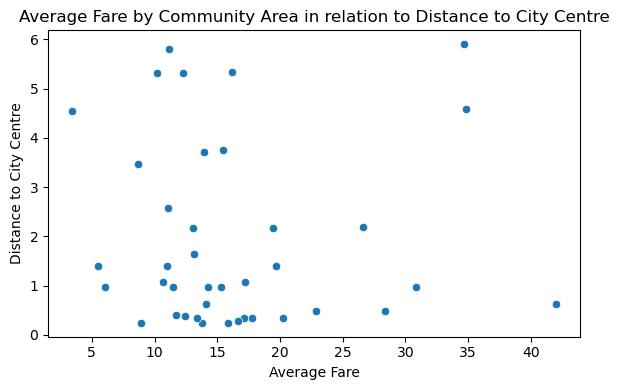

In [22]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=average_fare_per_pickup["trip_total"], y=geo_df_pickup["centre_distance"])

plt.title("Average Fare by Community Area in relation to Distance to City Centre")
plt.xlabel("Average Fare")
plt.ylabel("Distance to City Centre")

plt.tight_layout()
plt.show()


It seems like the location of the pickup community area does not seem to have a direct effect on the total price of a trip. Instead, we can see that the majority of points lies between an average fare of 10-20 dollars regardless pf the their distance to the city centre. Thus, we have trips with a distance of 6km to the city centre and those with a distance of under 1km that still have a similar average fare.

...